In [1]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import os
import ast
import random
import pandas as pd
from transformers import TrainingArguments, AutoTokenizer, HfArgumentParser
from utils.my_trainer import CustomTrainer
from utils.utils import my_compute_metrics,seed_everything
from typing import Optional
from dataclasses import dataclass, field
from model.qformer import Blip2QformerPatch
from peft import LoraConfig
from datasets import load_dataset, concatenate_datasets
from utils.data_collator import MyDataCollatorForQFormerPatch

/bask/projects/p/phwq4930-gbm/Zeyu/asiw9691_conda_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_name_list = ["CNX-PathLLM/Pathcap", "CNX-PathLLM/PubMedPath", "CNX-PathLLM/TwitterPath", "CNX-PathLLM/CleanedTextData"]
split_text = "train"
data_cache_dir = "/bask/projects/p/phwq4930-gbm/Zeyu/PathVLM/.cache"

clip_name = 'conch'
bert_name = 'microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext'

def formatting_func(examples):
    text = examples["txt"]
    examples["text"] = text
    return examples

In [3]:
dataset = []
eval_dataset = None

for dataset_name in dataset_name_list:
    one_dataset = load_dataset(dataset_name, split=split_text, cache_dir=data_cache_dir)
    one_dataset = one_dataset.rename_column('jpg', 'image')
    one_dataset = one_dataset.map(formatting_func, num_proc=4, remove_columns=['txt','__key__', '__url__'])
    dataset.append(one_dataset)

In [4]:
dataset = concatenate_datasets(dataset)
train_dataset = dataset

In [15]:
from tqdm import tqdm

widths = []
heights = []

# 遍历数据集并检查每个样本
for idx in tqdm(range(len(dataset))):
    example = dataset[idx]
    img = example["image"]
    width, height = img.size
    widths.append(width)
    heights.append(height)

100%|██████████| 480858/480858 [29:22<00:00, 272.79it/s]


In [22]:
import numpy as np
percentiles = np.percentile(widths, [10, 20, 30, 40, 50, 60, 70, 80, 90])
percentiles
percentiles = np.percentile(widths, [10, 20, 30, 40, 50, 60, 70, 80, 90])
percentiles

array([ 273.,  344.,  360.,  369.,  470.,  600.,  680.,  750., 1227.])

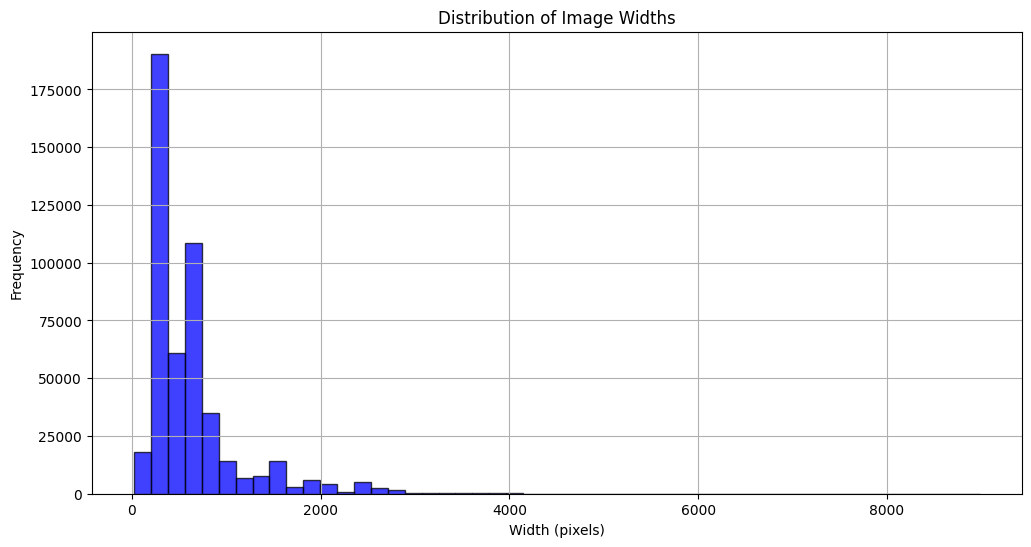

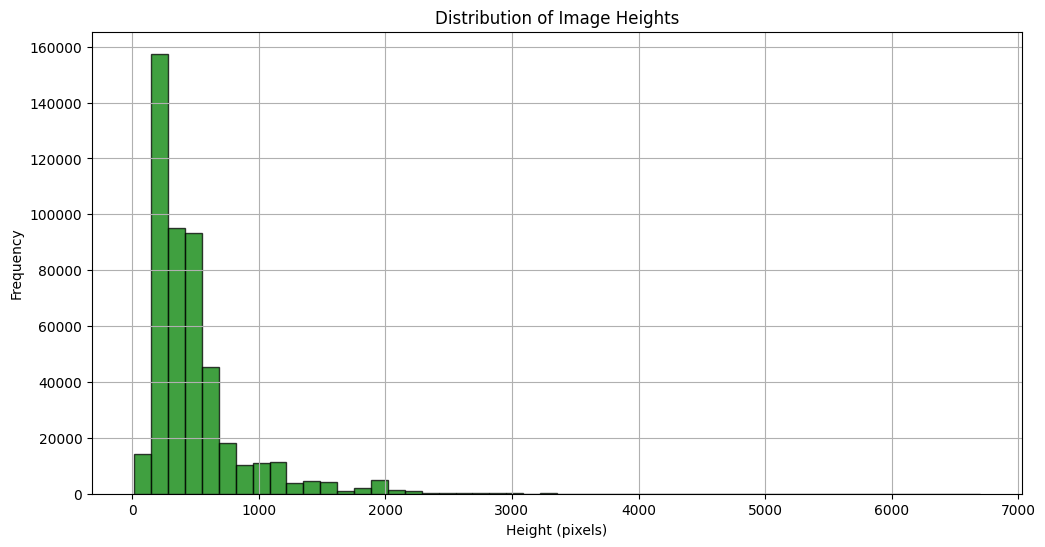

In [17]:
# 生成宽度的直方图
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.hist(widths, bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 生成高度的直方图
plt.figure(figsize=(12, 6))
plt.hist(heights, bins=50, alpha=0.75, color='green', edgecolor='black')
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [5]:
model = Blip2QformerPatch(clip_name = clip_name,
                            num_query_token=16,
                            cross_attention_freq=2,
                            embed_dim=256,
                            pretrain_name = bert_name,
                            max_txt_len = 256,)

vision_encoder loading ...


In [6]:
data_collator = MyDataCollatorForQFormerPatch(model.image_processor)

In [12]:
sampled_dataset = dataset.select(range(4))

In [14]:
batch = data_collator.torch_call(sampled_dataset)

In [16]:
batch["text"]

['Histopathological features of the lesion (H and E staining) at ×40.',
 'Representative myocardial tissue morphological injuries in the CPR + rhBNP groups. Myocardial injury in the rhBNP group was reduced compared with the placebo group, as characterized by perivascular edema (green arrows), myofibril derangement (black arrows), and neutrophil adhesion (yellow arrows) to the vascular endothelium.',
 'Light microscopy image of the thyroid gland in rats. R2-R4 groups. Hypothyroid tissue with variable form of thyroid follicles. The follicular thyrocytes had hypertrophy and hyperplasia.',
 'Microscopic features of sialolipoma showing a presence of lobules of mature adipose tissue separated by fibrous septae.']